# Interaction between two particles

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import subprocess
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import colormaps, rc
from scipy.linalg import eigh

sys.path.append('.')
from model import AssociativeMemory, get_embeddings


WIDTH = 8.5              # inches (from ICML style file)
HEIGHT = 8.5 / 1.618     # golden ratio

rc('font', family='serif', size=8)
usetex = not subprocess.run(['which', 'pdflatex']).returncode
rc('text', usetex=usetex)
if usetex:
    rc('text.latex', preamble=r'\usepackage{times}')

/home/vivc/.local/share/texlive/2022/bin/x86_64-linux/pdflatex


We consider the settings where $y = x$, $d=2$, $f_i$ is the canonical basis of $\R^2$, $u_y = f_y$, $e_1 = f_1$, $e_2 = \alpha f_1 + \sqrt{1-\alpha^2} f_2$.

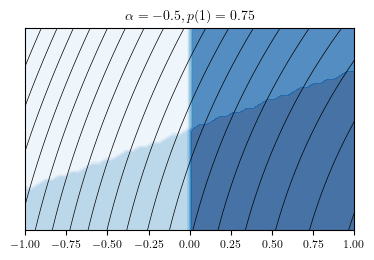

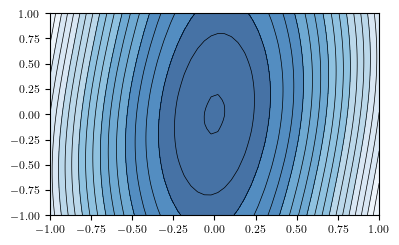

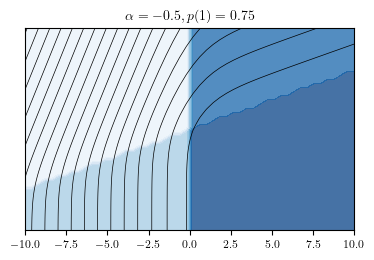

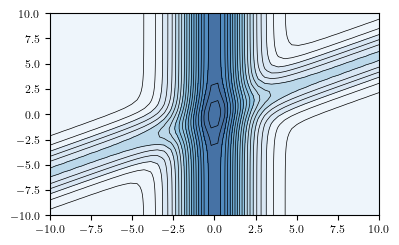

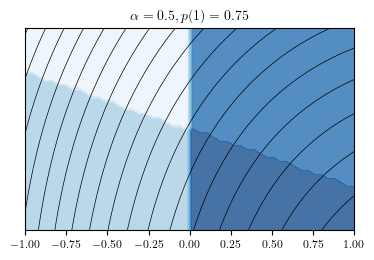

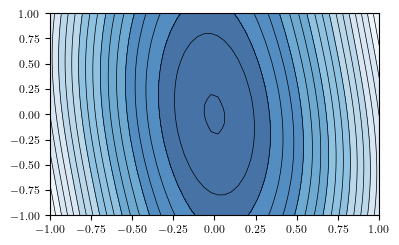

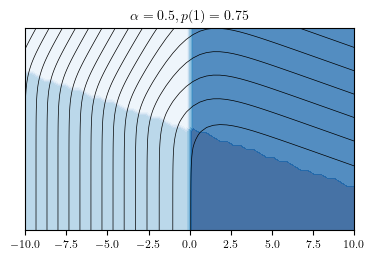

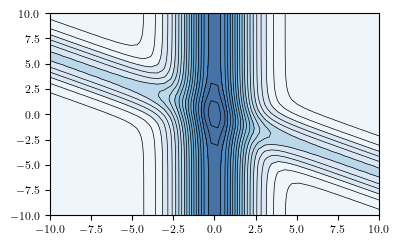

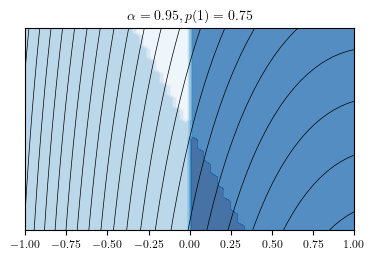

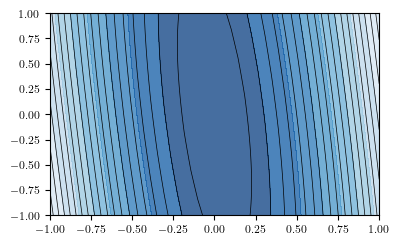

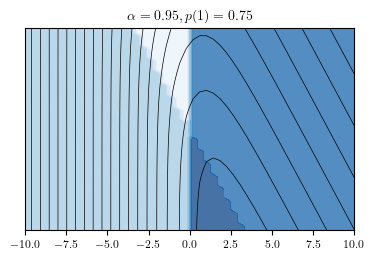

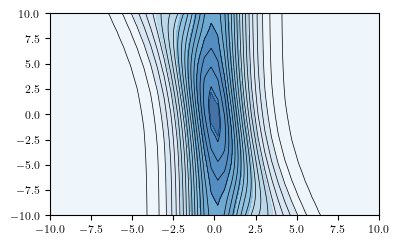

In [5]:

# hyparameters
n = 2
d = 2
p = .75         # probability of the first tokens

def f(x, epsilon=0):
    return x

# data
all_x = torch.arange(n)
all_y = f(all_x)
proba = torch.tensor([p, 1-p])
U = torch.eye(n)

for alpha, sign in zip([-.5, .5, .95], ['neg', 'pos', 'spike']):

    E = torch.eye(n)
    E[1,0] = alpha
    E[1,1] = np.sqrt(1-alpha**2)
    model = AssociativeMemory(E, U)

    for lim, res in zip([1, 10], ['close', 'far']):
        num = 50
        gamma_0, gamma_1 = np.meshgrid(np.linspace(-lim, lim, num=num), np.linspace(-lim, lim, num=num))

        Ws = np.zeros((num * num, d, d))
        Ws[:, 0, 0] = gamma_0.flatten()
        Ws[:, 1, 0] = gamma_1.flatten()
        Ws[:, 0, 1] = -Ws[:, 0, 0]
        Ws[:, 1, 1] = -Ws[:, 1, 0]
        Ws /= 2
        Ws = torch.tensor(Ws, dtype=torch.float32)

        score = E @ (Ws @ U.T)

        assert (score[:, 0, 0] - score[:, 0, 1] == torch.tensor(gamma_0.flatten(), dtype=torch.float32)).all()
        if alpha == 0:
            assert (score[:, 1, 0] - score[:, 1, 1] == torch.tensor(gamma_1.flatten(), dtype=torch.float32)).all()


        log_likelihood = F.log_softmax(score, dim=2)
        log_likelihood = log_likelihood[:, all_x, all_y]
        train_loss = (log_likelihood * (-proba)).mean(dim=1)
        Z = train_loss.numpy()
        fig, ax = plt.subplots(figsize=(.5 * WIDTH, .5 * HEIGHT))
        c = ax.contour(gamma_0, gamma_1, Z.reshape(num, num), levels=20, colors='k', linewidths=.5, linestyles='solid')

        pred = score.argmax(dim=2)
        pred = (pred != all_y).to(float)
        c = ax.contourf(gamma_0, gamma_1, (pred * proba).sum(dim=1).reshape((num, num)), cmap='Blues_r', alpha=.75)
        # ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(fr'$\alpha={alpha}, p(1)={p}$', fontsize=10)

        Z_sharpness = np.zeros((num**2, d**2))
        for i in range(num**2):
            model.W.data = Ws[i]
            Z_sharpness[i] = eigh(model.hessian(all_x, weight=proba).numpy(), eigvals_only=True)

        fig, ax = plt.subplots(figsize=(.5 * WIDTH, .5 * HEIGHT))
        c = ax.contour(gamma_0, gamma_1, Z_sharpness.max(axis=1).reshape(num, num), levels=20, colors='k', linewidths=.5, linestyles='solid')
        c = ax.contourf(gamma_0, gamma_1, Z_sharpness.max(axis=1).reshape((num, num)), cmap='Blues', alpha=.75)

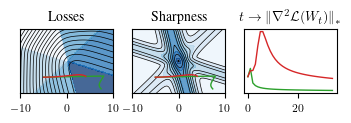

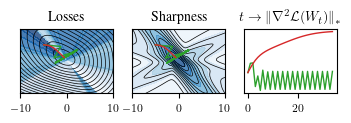

In [30]:
seeds = [39, 81, 7, 9]
ns = [3, 3, 30, 30]
x_mins = [-10, -2, -5, -1]
x_maxs = [10, 2, 5, .5]
y_mins = [-10, -2, -5, -.5]
y_maxs = [10, 2, 5, 1.5]

x_mins = [-10, -10, -10, -10]
x_maxs = [10, 10, 10, 10]
y_mins = [-10, -10, -10, -10]
y_maxs = [10, 10, 10, 10]

# hyparameters
d = 2
def f(x, epsilon=0):
    return x % 2


for seed, n, x_min, x_max, y_min, y_max in zip(seeds, ns, x_mins, x_maxs, y_mins, y_maxs):
    if seed in [81, 7]:
        continue
    torch.manual_seed(seed)

    # data
    all_x = torch.arange(n)
    all_y = f(all_x)

    alpha = 1
    proba = (all_x + 1.) ** (-alpha)
    proba /= proba.sum()

    E = get_embeddings(all_x.max() + 1, d, norm=True)
    U = torch.eye(d)

    model = AssociativeMemory(E, U)

    alpha = E[1:] @ E[0]

    num = 100
    gamma_0, gamma_1 = np.meshgrid(np.linspace(x_min, x_max, num=num), np.linspace(y_min, y_max, num=num))

    # lim = 1
    # gamma_0, gamma_1 = np.meshgrid(np.linspace(-lim, lim, num=num), np.linspace(-lim, lim, num=num))

    Ws = np.zeros((num * num, d, d))
    Ws[:, 0, 0] = gamma_0.flatten()
    Ws[:, 1, 0] = gamma_1.flatten()
    Ws[:, 0, 1] = -Ws[:, 0, 0]
    Ws[:, 1, 1] = -Ws[:, 1, 0]
    Ws /= 2
    Ws = torch.tensor(Ws, dtype=torch.float32)

    score = E @ (Ws @ U.T)
    log_likelihood = F.log_softmax(score, dim=2)
    log_likelihood = log_likelihood[:, all_x, all_y]
    train_loss = (log_likelihood * (-proba)).mean(dim=1)
    Z_train = train_loss.numpy()

    pred = score.argmax(dim=2)
    pred = (pred != all_y).to(float)
    Z_accuracy = (proba * pred).sum(dim=1)

    nb_epoch = 35
    lrs = [10, 1]

    gammas_0 = []
    gammas_1 = []
    all_sharpness = []

    model = AssociativeMemory(E, U)

    for lr in lrs:
        W_t = torch.zeros((nb_epoch, d, d))
        losses = torch.zeros(nb_epoch)
        sharpness = np.zeros(nb_epoch)

        x = -5
        y = -5
        if n != 3:
            y = 5
        # model.W.data[:] = 0
        model.W.data[0, 0] = x
        model.W.data[1, 0] = y
        model.W.data[0, 1] = -x
        model.W.data[1, 1] = -y
        model.W.data[:] /= 2
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0)

        for i in range(nb_epoch):
            W_t[i] = model.W.detach()

            # full batch
            x = all_x
            y = all_y

            # compute loss
            score = model(x)
            loss = (proba * F.cross_entropy(score, y, reduction='none')).sum()
            
            # update parameters with gradient descent
            optimizer.zero_grad()
            loss.backward()

            # record statistics
            with torch.no_grad():
                sharpness[i] = eigh(model.hessian(all_x, weight=proba).detach().numpy(), eigvals_only=True).max()

            # update parameters with gradient descent
            optimizer.step()

        gammas_0.append((W_t[:, 0, 0] - W_t[:, 0, 1]).numpy())
        gammas_1.append((W_t[:, 1, 0] - W_t[:, 1, 1]).numpy())
        all_sharpness.append(sharpness)

    fig, axes = plt.subplots(1, 3, figsize=(.48 * WIDTH, .48 * HEIGHT / 3))
    ax = axes[0]
    c = ax.contour(gamma_0, gamma_1, Z_train.reshape(num, num), levels=20, colors='k', linewidths=.5, linestyles='solid')
    c = ax.contourf(gamma_0, gamma_1, Z_accuracy.reshape((num, num)), levels=20, cmap='Blues_r', alpha=.75)
    # ax.set_xticks([])
    # ax.set_yticks([])

    i = np.argmin(Z_train)
    acc = Z_accuracy[i].item()
    ax.set_title(r'Losses', fontsize=10)

    for i in range(len(lrs)):
        a, = ax.plot(gammas_0[i], gammas_1[i], color='C' + str(i + 2), linewidth=1, linestyle='solid')
    ax.set_yticks([])

    Z_sharpness = np.zeros((num**2, d**2))
    for i in range(num**2):
        model.W.data = Ws[i]
        Z_sharpness[i] = eigh(model.hessian(all_x, weight=proba).numpy(), eigvals_only=True)

    ax = axes[1]
    c = ax.contour(gamma_0, gamma_1, Z_sharpness.max(axis=1).reshape(num, num), levels=10, colors='k', linewidths=.5, linestyles='solid')
    c = ax.contourf(gamma_0, gamma_1, Z_sharpness.max(axis=1).reshape((num, num)), cmap='Blues', alpha=.75)
    for i in range(len(lrs)):
        a, = ax.plot(gammas_0[i], gammas_1[i], color='C' + str(i + 2), linewidth=1, linestyle='solid')
    ax.set_title(r'Sharpness', fontsize=10)
    ax.set_yticks([])

    ax = axes[2]
    for i in range(len(lrs)):
        b, = ax.plot(all_sharpness[i], color='C' + str(i + 2), linewidth=1, linestyle='solid')
    ax.set_yticks([])
    ax.set_title(r'$t\to \|\nabla^2{\cal L}(W_t)\|_{*}$', fontsize=10)
    fig.savefig(f'two_particles_{seed}.pdf', bbox_inches='tight', pad_inches=0)

Optmization

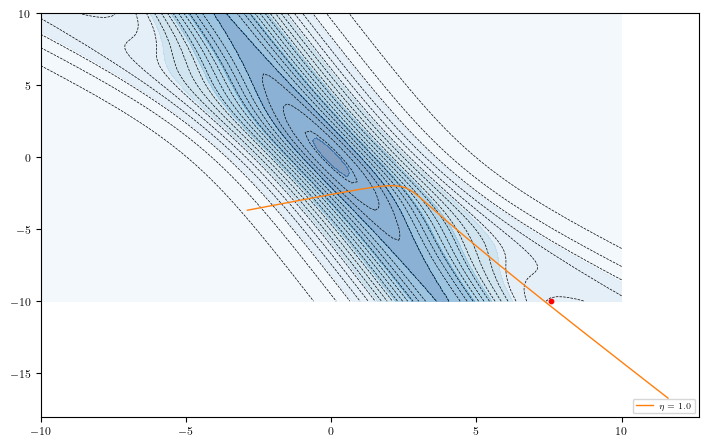

In [18]:

fig, ax = plt.subplots(figsize=(1 * WIDTH, 1 * HEIGHT))
c = ax.contour(gamma_0, gamma_1, Z_sharpness.max(axis=1).reshape(num, num), levels=20, colors='k', linewidths=.5, linestyles='--')

# fig, ax = plt.subplots(figsize=(.2 * WIDTH, .2 * HEIGHT))
# c = ax.contour(gamma_0, gamma_1, Z_train.reshape(num, num), levels=10, colors='k', linewidths=.5, linestyles='--')
c = ax.contourf(gamma_0, gamma_1, Z_sharpness.max(axis=1).reshape((num, num)), cmap='Blues', alpha=.5)

leg = []
for i in range(len(lrs)):
    a, = ax.plot(gammas_0[i], gammas_1[i], color='C' + str(i + 1), linewidth=1, linestyle='solid')
    leg.append(a)
ax.legend(leg, [rf'$\eta={lrs[i]}$' for i in range(len(lrs))], loc='lower right', fontsize=6, frameon=True, ncol=2)

i = np.argmin(Z_train)
ax.scatter(gamma_0.flatten()[i], gamma_1.flatten()[i], c='r', s=10)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_title(fr'SGD trajectory', fontsize=10)
# fig.savefig('forgetting_trajectory.pdf', bbox_inches='tight', pad_inches=0)

# fig.savefig('sharpness.pdf', bbox_inches='tight', pad_inches=0)

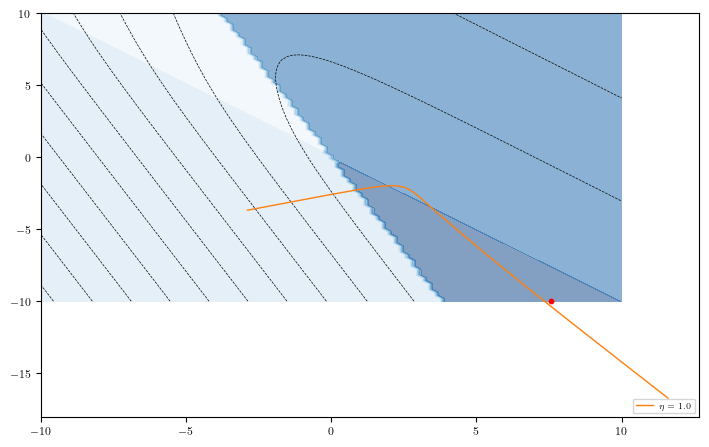

In [19]:

fig, ax = plt.subplots(figsize=(1 * WIDTH, 1 * HEIGHT))

# fig, ax = plt.subplots(figsize=(.2 * WIDTH, .2 * HEIGHT))
c = ax.contour(gamma_0, gamma_1, Z_train.reshape(num, num), levels=10, colors='k', linewidths=.5, linestyles='--')
c = ax.contourf(gamma_0, gamma_1, Z_accuracy.reshape((num, num)), cmap='Blues_r', alpha=.5)

leg = []
for i in range(len(lrs)):
    a, = ax.plot(gammas_0[i], gammas_1[i], color='C' + str(i + 1), linewidth=1, linestyle='solid')
    leg.append(a)
ax.legend(leg, [rf'$\eta={lrs[i]}$' for i in range(len(lrs))], loc='lower right', fontsize=6, frameon=True, ncol=2)

i = np.argmin(Z_train)
ax.scatter(gamma_0.flatten()[i], gamma_1.flatten()[i], c='r', s=10)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_title(fr'SGD trajectory', fontsize=10)
# fig.savefig('forgetting_trajectory.pdf', bbox_inches='tight', pad_inches=0)

# fig.savefig('sharpness.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 1.0, '$t\\to {\\cal L}(W_t)$')

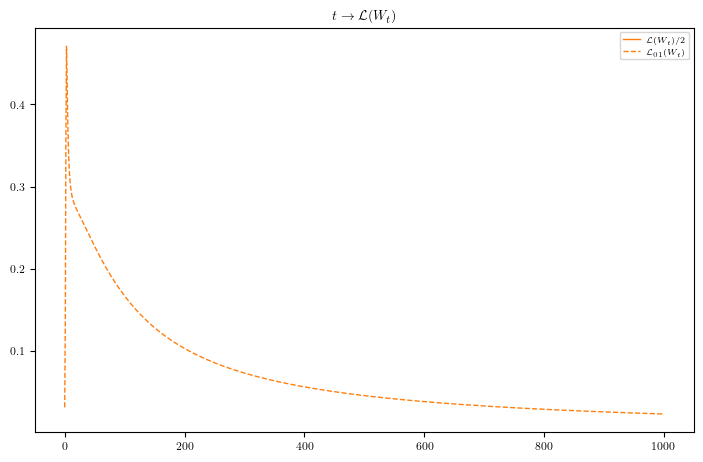

In [20]:
fig, ax = plt.subplots(figsize=(1 * WIDTH, 1 * HEIGHT))
for i in range(len(lrs)):
    # a, = ax.plot(all_losses[i] / 2, color='C' + str(i + 1), linewidth=1, alpha=1)
    # b, = ax.plot(1-all_accuracies[i], color='C' + str(i + 1), linewidth=1, linestyle='--')
    b, = ax.plot(all_sharpness[i], color='C' + str(i + 1), linewidth=1, linestyle='--')
# ax.plot(np.arange(nb_epoch), np.ones(nb_epoch) * 2 / lrs[0], color='k', linewidth=1, linestyle='--')
ax.legend([a, b], [r'${\cal L}(W_t) / 2$', r'${\cal L}_{01}(W_t)$'], loc='upper right', fontsize=6, frameon=True, ncol=1)
ax.set_title(r'$t\to {\cal L}(W_t)$', fontsize=10)
# fig.savefig('forgetting.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
2 / .35

5.714285714285714